# 09. Zarr Access for NetCDF4 files

## Timing:
- Exercise: 45 minutes

## Summary

Zarr is an open source library for storing N-dimensional array data.  It supports multidimensional arrays with attributes and dimensions similar to NetCDF4, and it can be read by XArray.  Zarr is often used for data held in cloud object storage (like Amazon S3), because it is better optimized for these situations than NetCDF4.

The [zarr-eosdis-store library](https://github.com/nasa/zarr-eosdis-store) allows NASA EOSDIS NetCDF4 files to be read more efficiently by transferring only file metadata and data needed for computation in a small number of requests, rather than moving the whole file or making many small requests.  It works by making the files directly readable by the [Zarr Python library](https://zarr.readthedocs.io) and XArray across a network.  To use it, files must have a corresponding metadata file ending in `.dmrpp`, which increasingly true for cloud-accessible EOSDIS data.  https://github.com/nasa/zarr-eosdis-store

The zarr-eosdis-store library provides several benefits over downloading EOSDIS data files and accessing them using XArray, NetCDF4, or HDF5 Python libraries:

* It only downloads the chunks of data you actually read, so if you don't read all variables or the full spatiotemporal extent of a file, you usually won't spend time downloading those portions of the file
* It parallelizes and optimizes downloads for the portions of files you do read, so download speeds can be faster in general
* It automatically interoperates with Earthdata Login if you have a .netrc file set up
* It is aware of some EOSDIS cloud implementation quirks and provides caching that can save time for repeated requests to individual files

It can also be faster than using XArray pointing NetCDF4 files with s3:// URLs, depending on the file's internal structure, and is often more convenient.

Consider using this library when:
1. The portion of the data file you need to use is much smaller than the full file, e.g. in cases of spatial subsets or reading a single variable from a file containing several
1. s3:// URLs are not readily available
1. Code need to run outside of the AWS cloud or us-west-2 region or in a hybrid cloud / non-cloud manner
1. s3:// access using XArray seems slower than you would expect (possibly due to unoptimized internal file structure)
1. No readily-available, public, cloud-optimized version of the data exists already. The example we show _is_ also available as an AWS Public Dataset: https://registry.opendata.aws/mur/
1. Adding ".dmrpp" to the end of a data URL returns a file

### Objectives

1. Build on prior knowledge from CMR and Earthdata Login tutorials
2. Work through an example of using the EOSDIS Zarr Store to access data using XArray
3. Learn about the Zarr format and library for accessing data in the cloud



## Exercise

In this exercise, we will be using the eosdis-zarr-store library to aggregate and analyze a month of sea surface temperature for the Great Lakes region

### Set up

#### Import Required Packages

In [1]:
pip install zarr-eosdis-store


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pqdm

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Core libraries for this tutorial
# Available via `pip install zarr zarr-eosdis-store`
from eosdis_store import EosdisStore
import xarray as xr

# Other Python libraries
import requests
from pqdm.threads import pqdm
from matplotlib import animation, pyplot as plt
from IPython.core.display import display, HTML

# Python standard library imports
from pprint import pprint

Also set the width / height for plots we show

In [4]:
plt.rcParams['figure.figsize'] = 12, 6

#### Set Dataset, Time, and Region of Interest

Look in PO.DAAC's cloud archive for Group for High Resolution Sea Surface Temperature (GHRSST) Level 4 Multiscale Ultrahigh Resolution (MUR) data

- MUR-JPL-L4-GLOB-v4.1

- AVHRR_OI-NCEI-L4-GLOB-v2.0

In [5]:
data_provider = 'POCLOUD'
mur_short_name = 'MUR-JPL-L4-GLOB-v4.1'

Looking for data 

In [6]:
start_time = '2017-09-01T21:00:00Z'
end_time = '2018-09-30T20:59:59Z'

# Bounding box around the Great Lakes
#lats = slice(41, 49)
#lons = slice(-93, -76)

# Some other possibly interesting bounding boxes:

# Bounding box around the California CoastLine
lats = slice(26, 46)
lons = slice(-130, -110)

# Hawaiian Islands
# lats = slice(18, 22.5)
# lons = slice(-161, -154)

# Mediterranean Sea
# lats = slice(29, 45)
# lons = slice(-7, 37)

### Find URLs for the dataset and AOI

Set up a CMR granules search for our area of interest, as we saw in prior tutorials

In [7]:
cmr_url = 'https://cmr.earthdata.nasa.gov/search/granules.json'

Search for granules in our area of interest, expecting one granule per day of September

In [8]:
response = requests.get(cmr_url, 
                        params={
                            'provider': data_provider,
                            'short_name': mur_short_name, 
                            'temporal': f'{start_time},{end_time}',
                            'bounding_box': f'{lons.start},{lats.start},{lons.stop},{lats.stop}',
                            'page_size': 2000,
                            }
                       )

In [9]:
granules = response.json()['feed']['entry']

for granule in granules:
    print(granule['title'])

20170901090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20170902090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20170903090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20170904090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20170905090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20170906090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20170907090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20170908090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20170909090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20170910090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20170911090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20170912090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20170913090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20170914090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20170915090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20170916090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20170917090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
20170918090000

In [10]:
pprint(granules[0])

{'boxes': ['-90 -180 90 180'],
 'browse_flag': False,
 'collection_concept_id': 'C1996881146-POCLOUD',
 'coordinate_system': 'CARTESIAN',
 'data_center': 'POCLOUD',
 'dataset_id': 'GHRSST Level 4 MUR Global Foundation Sea Surface Temperature '
               'Analysis (v4.1)',
 'day_night_flag': 'UNSPECIFIED',
 'granule_size': '385.90079402923584',
 'id': 'G2028234741-POCLOUD',
 'links': [{'href': 's3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20170901090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
            'hreflang': 'en-US',
            'rel': 'http://esipfed.org/ns/fedsearch/1.1/s3#',
            'title': 'This link provides direct download access via S3 to the '
                     'granule.'},
           {'href': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/MUR-JPL-L4-GLOB-v4.1/20170901090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc.md5',
            'hreflang': 'en-US',
            'rel': 'http://esipfed.org/ns/fedsearch/1.1/metad

In [11]:
urls = []
for granule in granules:
    for link in granule['links']:
        if link['rel'].endswith('/data#'):
            urls.append(link['href'])
            break
pprint(urls)

['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20170901090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20170902090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20170903090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20170904090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20170905090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20170906090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cum

### Open and view our AOI without downloading a whole file

#### Check to see if we can use an efficient partial-access technique

In [12]:
response = requests.head(f'{urls[0]}.dmrpp')

print('Can we use EosdisZarrStore and XArray to access these files more efficiently?')
print('Yes' if response.ok else 'No')

Can we use EosdisZarrStore and XArray to access these files more efficiently?
Yes


In [13]:
# Listing Datasets in workspace 
!ls /datasets/file

ls: /datasets/file: No such file or directory


- A netrc file (. netrc or _netrc) is used to hold credentials necessary to login to your LabKey Server and authorize access to data stored there. 

1. Set up your EarthData Login by going to https://urs.earthdata.nasa.gov

2. If you are on a Mac you can use your terminal to set up a file

- cd Desktop
- mkdir [name of folder]
- nano [name of file = .netrc]
- touch [.netrc]
> > machine urs.earthdata.nasa.gov 
> > login *email*
> > password *password*
- Save File = ctrl + X 

Thats it! 
now you can run netrc file in notebook 


- The netrc file contains authentication for connecting to one or more machines, often used when working with APIs or scripting languages.

In [14]:
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass
import os

In [15]:
urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

# Determine the OS (Windows machines usually use an '_netrc' file)
netrc_name = "_netrc" if system()=="Windows" else ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

    # Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen('echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)

Open our first URL using the Zarr library

In [16]:
from eosdis_store import EosdisStore
import zarr

# Assumes you have set up .netrc with your Earthdata Login information
f = zarr.open(EosdisStore('https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210901090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'))


In [17]:
url = urls[0]

ds = xr.open_zarr(EosdisStore(url), consolidated=False)

/usr/local/lib/python3.9/site-packages/zarr/storage.py:2886: UserWarning: Store {'.zgroup': {'zarr_format': 2}, 'analysed_sst/.zarray': {'zarr_format': 2, 'filters': [{'id': 'shuffle', 'elementsize': 2}], 'order': 'C', 'dtype': '<i2', 'shape': [1, 17999, 36000], 'compressor': {'id': 'zlib', 'level': 4}, 'chunks': [1, 1023, 2047], 'fill_value': -32768}, 'analysed_sst/.zattrs': {'long_name': 'analysed sea surface temperature', 'standard_name': 'sea_surface_foundation_temperature', 'units': 'kelvin', '_FillValue': -32768, 'add_offset': 298.15, 'scale_factor': 0.001, 'valid_min': -32767, 'valid_max': 32767, 'comment': '\\"Final\\" version using Multi-Resolution Variational Analysis (MRVA) method for interpolation', 'coordinates': 'lon lat', 'source': 'AMSR2-REMSS, AVHRR19_G-NAVO, AVHRR_METOP_A-EUMETSAT, MODIS_A-JPL, MODIS_T-JPL, iQUAM-NOAA/NESDIS, Ice_Conc-OSISAF', '_ARRAY_DIMENSIONS': ['time', 'lat', 'lon']}, 'analysed_sst/.zchunkstore': {'0.0.0': {'offset': 44006, 'size': 4083}, '0.0.1':

In [18]:
# This will show dictionary-like containers of Data-arrays 
ds['analysed_sst']

<xarray.DataArray 'analysed_sst' (time: 1, lat: 17999, lon: 36000)>
[647964000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2017-09-01T09:00:00
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        \"Final\" version using Multi-Resolution Variational Anal...
    source:         AMSR2-REMSS, AVHRR19_G-NAVO, AVHRR_METOP_A-EUMETSAT, MODI...

# This works
data = xr.open_mfdataset(fileset, combine='by_coords', engine='h5netcdf' )

In [19]:
ds

<xarray.Dataset>
Dimensions:           (time: 1, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2017-09-01T09:00:00
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

That's it!  No downloads, temporary credentials, or S3 filesystems.  Hereafter, we interact with the `ds` variable as with any XArray dataset.  We need not worry about the EosdisStore anymore.

View the file's variable structure

In [20]:
sst = ds.analysed_sst.sel(lat=lats, lon=lons)
sst

<xarray.DataArray 'analysed_sst' (time: 1, lat: 2001, lon: 2001)>
[4004001 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 26.0 26.01 26.02 26.03 ... 45.97 45.98 45.99 46.0
  * lon      (lon) float32 -130.0 -130.0 -130.0 -130.0 ... -110.0 -110.0 -110.0
  * time     (time) datetime64[ns] 2017-09-01T09:00:00
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        \"Final\" version using Multi-Resolution Variational Anal...
    source:         AMSR2-REMSS, AVHRR19_G-NAVO, AVHRR_METOP_A-EUMETSAT, MODI...

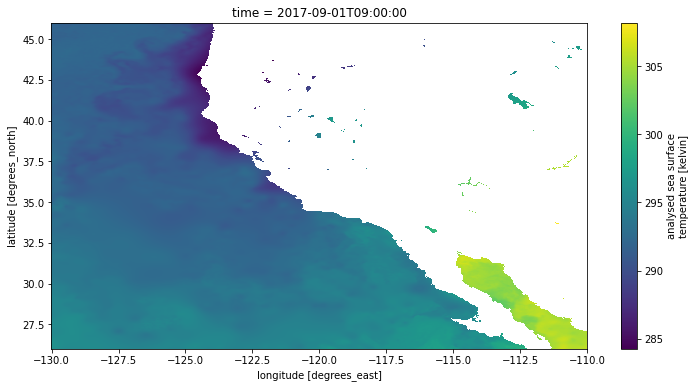

In [21]:
sst.plot()

In [22]:
!pip install rioxarray==0.11.1

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 570.9 kB/s eta 0:00:00 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for rioxarray: filename=rioxarray-0.11.1-py2.py3-none-any.whl size=50942 sha256=b9e8c640ef52f45474c22ff5cd4e2c594cb3f8bcc59670b4975bc4798e081bd9
  Stored in directory: /Users/jtrobert/Library/Caches/pip/wheels/9f/62/ba/1ee5bdf78935aaa4a15929c89a39bb8cd999dae01362082893
Successfully built rioxarray
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussi

In [23]:
import rioxarray

ds.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:           (time: 1, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2017-09-01T09:00:00
    spatial_ref       int64 0
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [25]:
ds["analysed_sst"].rio.to_raster('./analysed_sst.tif')

In [26]:
pip install pandas

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd

In [28]:
ds['lat']

<xarray.DataArray 'lat' (lat: 17999)>
array([-89.99, -89.98, -89.97, ...,  89.97,  89.98,  89.99], dtype=float32)
Coordinates:
  * lat          (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
    spatial_ref  int64 0
Attributes:
    long_name:      latitude
    standard_name:  latitude
    axis:           Y
    units:          degrees_north
    valid_min:      -90.0
    valid_max:      90.0
    comment:        none

In [29]:
# pd.DataFrame(ds['analysed_sst'][:])

In [30]:
df = pd.DataFrame(ds)

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_array()` method.

In [ ]:
df2 = pd.DataFrame(ds['lat'])

In [ ]:
#df3 = pd.DataFrame(ds['analysed_sst'][0])

In [31]:
sst

<xarray.DataArray 'analysed_sst' (time: 1, lat: 2001, lon: 2001)>
[4004001 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 26.0 26.01 26.02 26.03 ... 45.97 45.98 45.99 46.0
  * lon      (lon) float32 -130.0 -130.0 -130.0 -130.0 ... -110.0 -110.0 -110.0
  * time     (time) datetime64[ns] 2017-09-01T09:00:00
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        \"Final\" version using Multi-Resolution Variational Anal...
    source:         AMSR2-REMSS, AVHRR19_G-NAVO, AVHRR_METOP_A-EUMETSAT, MODI...

In [32]:
pip install -U unfolded.data-sdk

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 3.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 1.0 MB/s eta 0:00:0000:01
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation sch

In [33]:
from unfolded.data_sdk import DataSDK


In [34]:
pip install netCDF4

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [35]:
#Reading Large Files 
#Read Meta Data Information First

%matplotlib inline
from netCDF4 import Dataset    

In [36]:
#data = xr.open_mfdataset(ds, combine='by_coords', engine='netcdf4' )
ds['analysed_sst'][:][:]

<xarray.DataArray 'analysed_sst' (time: 1, lat: 17999, lon: 36000)>
array([[[   nan,    nan, ...,    nan,    nan],
        [   nan,    nan, ...,    nan,    nan],
        ...,
        [271.35, 271.35, ..., 271.35, 271.35],
        [271.35, 271.35, ..., 271.35, 271.35]]], dtype=float32)
Coordinates:
  * lat          (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon          (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time         (time) datetime64[ns] 2017-09-01T09:00:00
    spatial_ref  int64 0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        \"Final\" version using Multi-Resolution Variational Anal...
    source:         AMSR2-REMSS, AVHRR19_G-NAVO, AVHRR_METOP_A-EUMETSAT, MODI...

In [37]:
# xr.open_zarr(EosdisStore(url), consolidated=False)

ds_hist = xr.open_zarr(EosdisStore(url), consolidated = False)



/usr/local/lib/python3.9/site-packages/zarr/storage.py:2886: UserWarning: Store {'.zgroup': {'zarr_format': 2}, 'analysed_sst/.zarray': {'zarr_format': 2, 'filters': [{'id': 'shuffle', 'elementsize': 2}], 'order': 'C', 'dtype': '<i2', 'shape': [1, 17999, 36000], 'compressor': {'id': 'zlib', 'level': 4}, 'chunks': [1, 1023, 2047], 'fill_value': -32768}, 'analysed_sst/.zattrs': {'long_name': 'analysed sea surface temperature', 'standard_name': 'sea_surface_foundation_temperature', 'units': 'kelvin', '_FillValue': -32768, 'add_offset': 298.15, 'scale_factor': 0.001, 'valid_min': -32767, 'valid_max': 32767, 'comment': '\\"Final\\" version using Multi-Resolution Variational Analysis (MRVA) method for interpolation', 'coordinates': 'lon lat', 'source': 'AMSR2-REMSS, AVHRR19_G-NAVO, AVHRR_METOP_A-EUMETSAT, MODIS_A-JPL, MODIS_T-JPL, iQUAM-NOAA/NESDIS, Ice_Conc-OSISAF', '_ARRAY_DIMENSIONS': ['time', 'lat', 'lon']}, 'analysed_sst/.zchunkstore': {'0.0.0': {'offset': 44006, 'size': 4083}, '0.0.1':

In [38]:
# Printing Date Range
print('hist date range  :', ds_hist.time[0].values, ' , ', ds_hist.time[-1].values)

hist date range  : 2017-09-01T09:00:00.000000000  ,  2017-09-01T09:00:00.000000000


In [39]:
ds

<xarray.Dataset>
Dimensions:           (time: 1, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2017-09-01T09:00:00
    spatial_ref       int64 0
Data variables:
    analysed_sst      (time, lat, lon) float32 nan nan nan ... 271.4 271.4 271.4
    analysis_error    (time, lat, lon) float32 ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e1131692-8e9f-4f53-a533-630eb3dc66f4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>